# CytoTable mise en place (general overview)

This notebook includes a quick demonstration of CytoTable to help you understand the basics of using the package and the biological basis of each step.
We provide a high-level overview of the related concepts to give greater context about where and how the data are changed in order to gain new insights.

The name of the notebook comes from the french _mise en place_:
> "Mise en place (French pronunciation: [mi zɑ̃ ˈplas]) is a French culinary phrase which means "putting in place"
> or "gather". It refers to the setup required before cooking, and is often used in professional kitchens to
> refer to organizing and arranging the ingredients ..."
> - [Wikipedia](https://en.wikipedia.org/wiki/Mise_en_place)

In [1]:
import pathlib
from collections import Counter

import pandas as pd
import pyarrow.parquet as pq
from IPython.display import Image, display
from PIL import Image

import cytotable

# setup variables for use throughout the notebook
source_path = "../../../tests/data/cellprofiler/examplehuman"
dest_path = "./example.parquet"

In [2]:
# remove the dest_path if it's present
if pathlib.Path(dest_path).is_file():
    pathlib.Path(dest_path).unlink()

In [3]:
# show the files we will use as source data with CytoTable
list(pathlib.Path(source_path).glob("*"))

[PosixPath('../../../tests/data/cellprofiler/examplehuman/Experiment.csv'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/PH3.csv'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/Cytoplasm.csv'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/Image.csv'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/ExampleHuman.cppipe'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/AS_09125_050116030001_D03f00d0_Overlay.png'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/AS_09125_050116030001_D03f00d0.tif'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/AS_09125_050116030001_D03f00d1.tif'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/Nuclei.csv'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/AS_09125_050116030001_D03f00d2.tif'),
 PosixPath('../../../tests/data/cellprofiler/examplehuman/Cells.csv')]

## Phase 1: Cells are stained and images are captured by microscopes

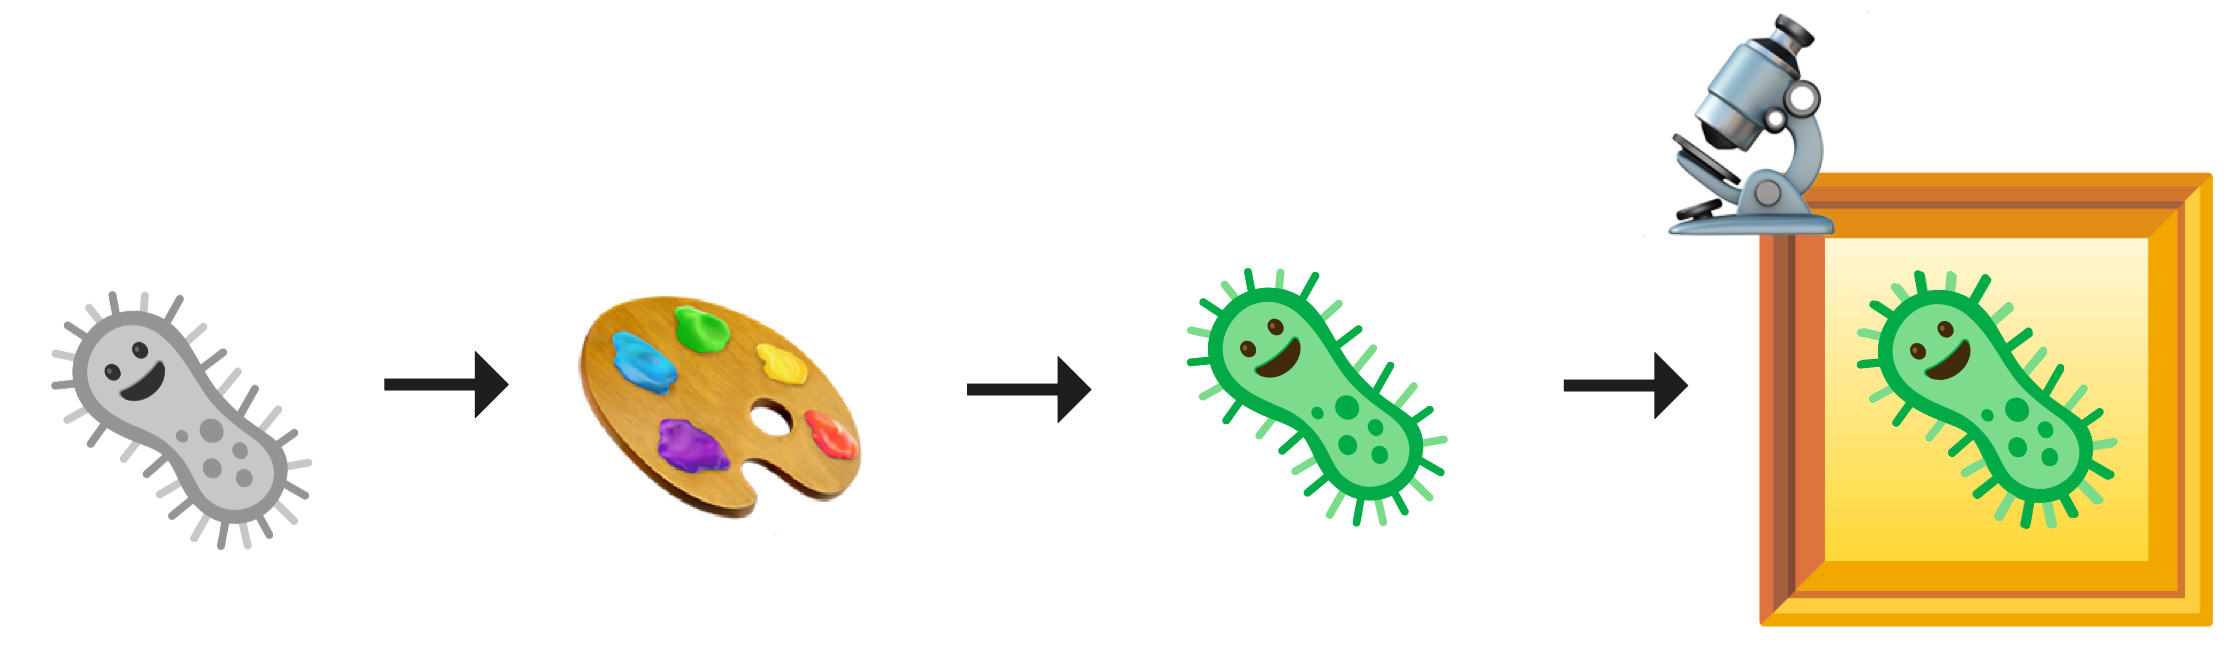

__Figure 1.__ _Cells are stained in order to highlight cellular compartments and organelles. Microscopes are used to observe and capture data for later use._

CytoTable uses data created from multiple upstream steps involving images of 
stained biological objects (typically cells).
Cells are cultured in multi-well plates, perturbed, and then fixed before being stained with a panel of six fluorescent dyes that highlight key cellular compartments and organelles, including the nucleus, nucleoli/RNA, endoplasmic reticulum, mitochondria, actin cytoskeleton, Golgi apparatus, and plasma membrane. These multiplexed stains are imaged across fluorescence channels using automated high-content microscopy, producing rich images that capture the morphology of individual cells for downstream analysis ([Bray et al., 2016](https://doi.org/10.1038/nprot.2016.105); [Gustafsdottir et al., 2013](https://doi.org/10.1371/journal.pone.0080999)).

We use the ExampleHuman dataset provided from CellProfiler Examples ([Moffat et al., 2006](https://doi.org/10.1016/j.cell.2006.01.040), [CellProfiler Examples Link](https://github.com/CellProfiler/examples/tree/master/ExampleHuman)) to help describe this process below.


Image with stain: DNA


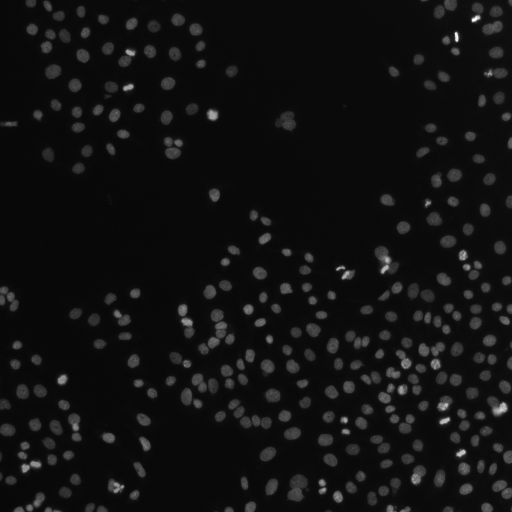


Image with stain: PH3


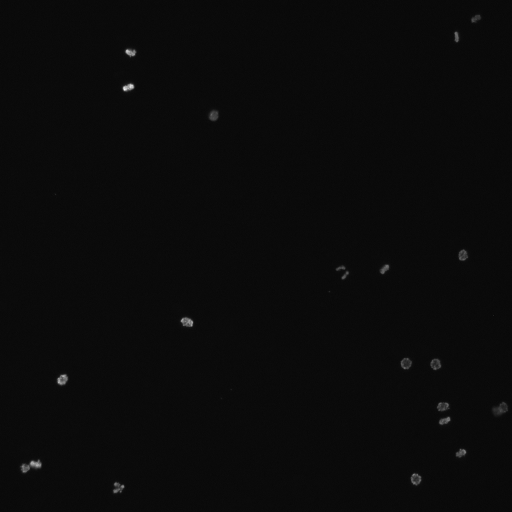


Image with stain: Cells


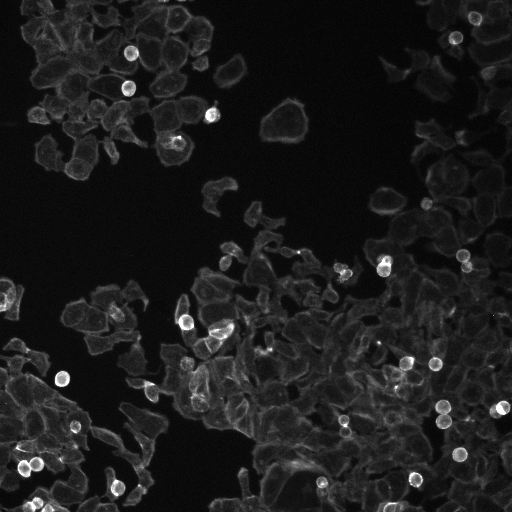

In [4]:
# display the images we will gather features from
image_name_map = {"d0.tif": "DNA", "d1.tif": "PH3", "d2.tif": "Cells"}

for image in pathlib.Path(source_path).glob("*.tif"):
    stain = ""
    for key, val in image_name_map.items():
        if key in str(image):
            stain = val
    print(f"\nImage with stain: {stain}")
    display(Image.open(image))

## Phase 2: Images are segmented to build numeric feature datasets via CellProfiler

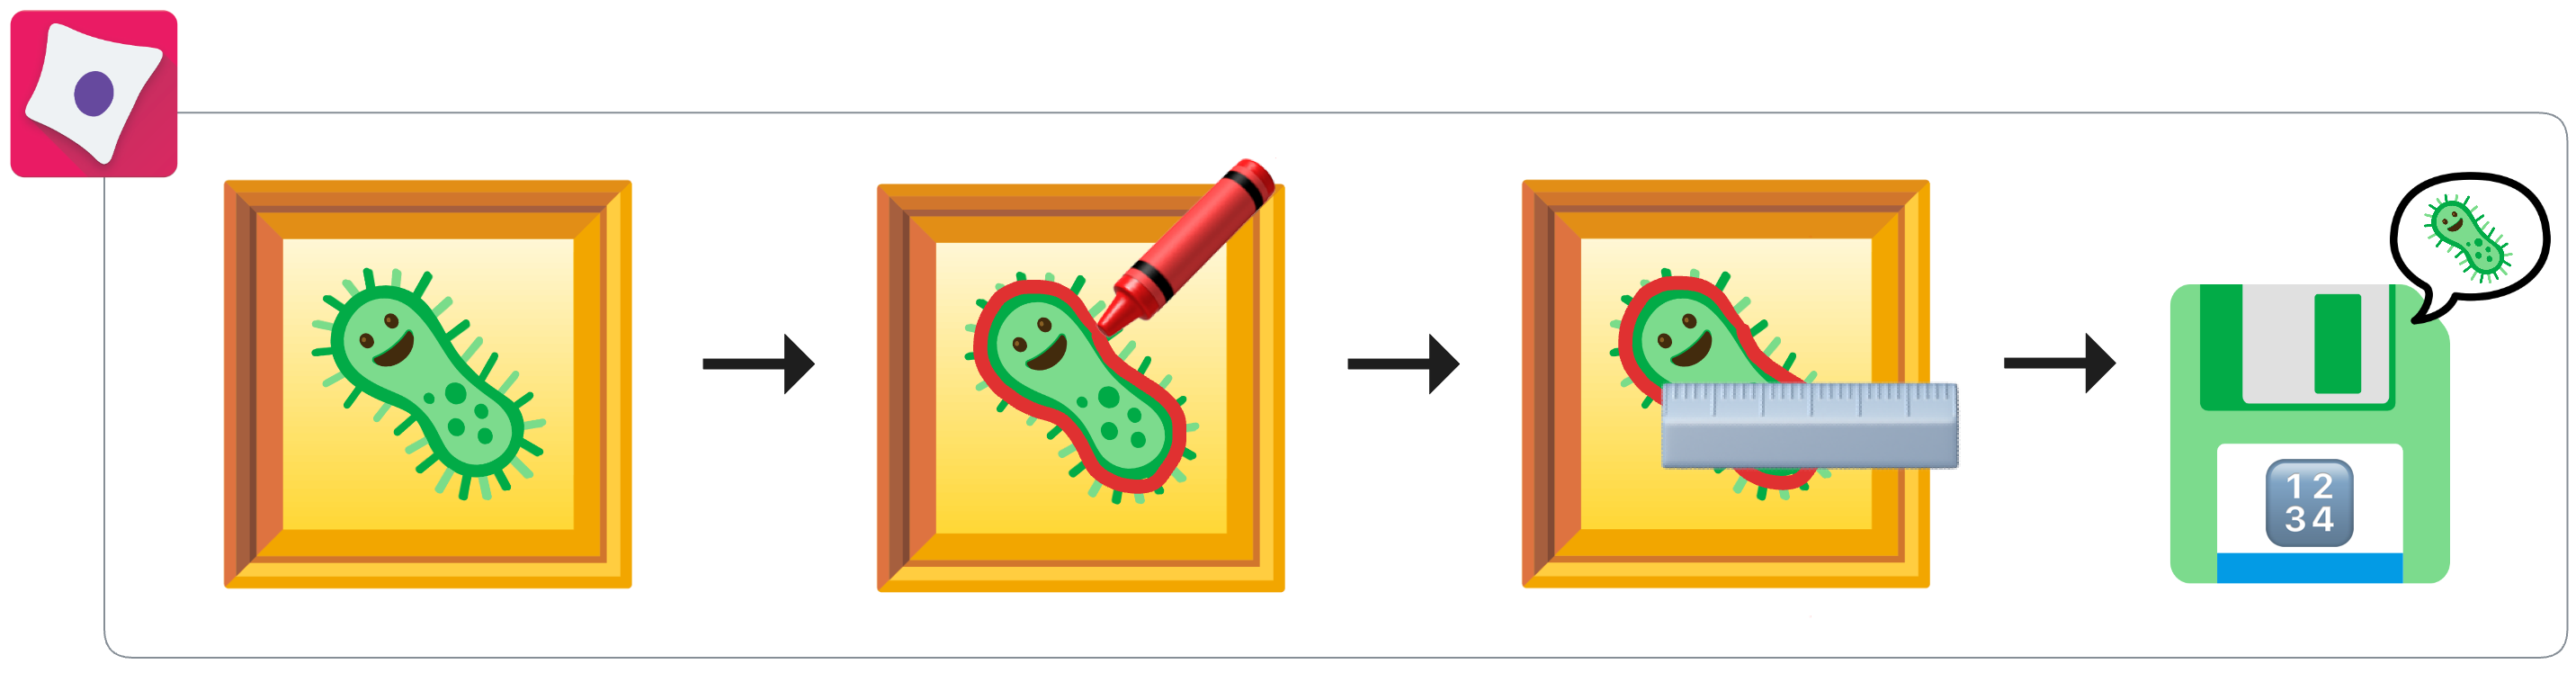

__Figure 2.__ _CellProfiler is configured to use images and performs segmentation to evaluate numeric representations of cells. This data is captured for later use in tabular file formats such as CSV or SQLite tables._

After acquisition, the multiplexed images are processed using image-analysis software such as CellProfiler, which segments cells and their compartments into distinct regions of interest. From these segmented images, hundreds to thousands of quantitative features are extracted per cell, capturing properties such as size, shape, intensity, texture, and spatial organization.
These high-dimensional feature datasets provide a numerical representation of cell morphology that serves as the foundation for downstream profiling and analysis ([Carpenter et al., 2006](https://doi.org/10.1186/gb-2006-7-10-r100)).

CellProfiler was used in conjunction with the `.cppipe` file to produce the following images and data tables from the ExampleHuman dataset.

Image outlines from segmentation (composite)
Color key: (dark blue: nuclei, light blue: cells, yellow: PH3)


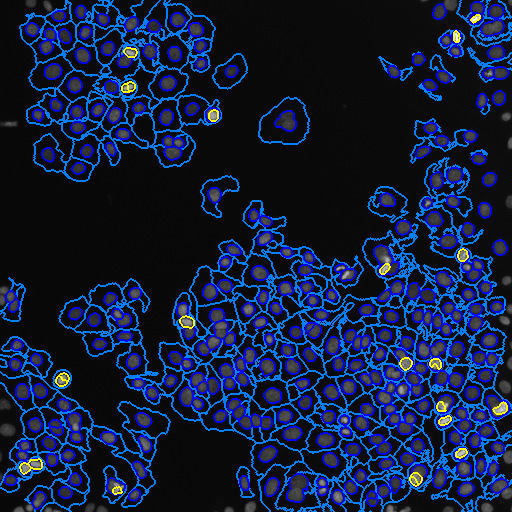

In [5]:
# show the segmentations through an overlay with outlines
for image in pathlib.Path(source_path).glob("*Overlay.png"):
    print(f"Image outlines from segmentation (composite)")
    print("Color key: (dark blue: nuclei, light blue: cells, yellow: PH3)")
    display(Image.open(image))

In [6]:
# show the tables generated  from the resulting CSV files
for profiles in pathlib.Path(source_path).glob("*.csv"):
    print(f"\nProfiles from CellProfiler: {profiles}")
    display(pd.read_csv(profiles).head())


Profiles from CellProfiler: ../../../tests/data/cellprofiler/examplehuman/Experiment.csv


,Key,Value
0,CellProfiler_Version,4.0.6
1,ChannelType_DNA,Grayscale
2,ChannelType_PH3,Grayscale
3,ChannelType_cellbody,Grayscale
4,ImageSet_Zip_Dictionary,b'eG1sMS4wImNvP09NRXd3Lm9wLmhtL09NRS0+PEltYWdl...



Profiles from CellProfiler: ../../../tests/data/cellprofiler/examplehuman/PH3.csv


,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,Location_Center_Z,Number_Object_Number,Parent_Nuclei
0,1,1,475.232558,18.162791,0,1,7
1,1,2,456.096154,36.326923,0,2,17
2,1,3,130.119565,51.967391,0,3,25
3,1,4,130.660714,85.982143,0,4,41
4,1,5,124.891304,87.913043,0,5,41



Profiles from CellProfiler: ../../../tests/data/cellprofiler/examplehuman/Cytoplasm.csv


,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Location_Center_Y,Location_MaxIntensity_X_DNA,Location_MaxIntensity_X_PH3,Location_MaxIntensity_Y_DNA,Location_MaxIntensity_Y_PH3,Location_MaxIntensity_Z_DNA,Location_MaxIntensity_Z_PH3,Number_Object_Number,Parent_Cells,Parent_Nuclei
0,1,1,288,580,486,20,457,0,468.621528,7.739583,...,7.739583,478.0,478.0,12.0,13.0,0.0,0.0,1,1,1
1,1,2,256,475,511,19,486,0,496.113281,9.058594,...,9.058594,493.0,503.0,16.0,16.0,0.0,0.0,2,2,2
2,1,3,52,195,446,19,433,4,439.000000,11.269231,...,11.269231,443.0,433.0,8.0,12.0,0.0,0.0,3,3,3
3,1,4,466,972,103,27,67,0,81.849785,9.175966,...,9.175966,83.0,73.0,15.0,19.0,0.0,0.0,4,4,4
4,1,5,296,729,72,27,45,0,59.597973,15.952703,...,15.952703,62.0,66.0,12.0,0.0,0.0,0.0,5,5,5



Profiles from CellProfiler: ../../../tests/data/cellprofiler/examplehuman/Image.csv


,Channel_DNA,Channel_PH3,Channel_cellbody,Count_Cells,Count_Cytoplasm,Count_Nuclei,Count_PH3,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,...,Threshold_WeightedVariance_Cells,Threshold_WeightedVariance_Nuclei,Threshold_WeightedVariance_PH3,URL_DNA,URL_OrigOverlay,URL_PH3,URL_cellbody,Width_DNA,Width_PH3,Width_cellbody
0,-1,-1,-1,289.0,289.0,289.0,22.0,0.0,0.0,5.08,...,0.334916,0.130342,0.018841,file:/usr/local/src/ExampleHuman/images/AS_091...,file:output/ExampleHuman/AS_09125_050116030001...,file:/usr/local/src/ExampleHuman/images/AS_091...,file:/usr/local/src/ExampleHuman/images/AS_091...,512,512,512



Profiles from CellProfiler: ../../../tests/data/cellprofiler/examplehuman/Nuclei.csv


,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Location_Center_X,Location_Center_Y,Location_Center_Z,Location_MaxIntensity_X_DNA,Location_MaxIntensity_X_PH3,Location_MaxIntensity_Y_DNA,Location_MaxIntensity_Y_PH3,Location_MaxIntensity_Z_DNA,Location_MaxIntensity_Z_PH3,Number_Object_Number
0,1,1,131,156,484,14,471,2,477.099237,7.580153,...,477.099237,7.580153,0,477.0,478.0,8.0,13.0,0.0,0.0,1
1,1,2,152,195,504,18,489,5,495.750000,11.098684,...,495.750000,11.098684,0,495.0,502.0,9.0,14.0,0.0,0.0,2
2,1,3,147,195,446,19,433,4,438.959184,11.374150,...,438.959184,11.374150,0,440.0,439.0,11.0,16.0,0.0,0.0,3
3,1,4,98,130,86,18,76,5,80.459184,11.163265,...,80.459184,11.163265,0,80.0,81.0,13.0,10.0,0.0,0.0,4
4,1,5,104,130,65,21,52,11,58.423077,15.509615,...,58.423077,15.509615,0,62.0,52.0,14.0,15.0,0.0,0.0,5



Profiles from CellProfiler: ../../../tests/data/cellprofiler/examplehuman/Cells.csv


,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Location_Center_Y,Location_Center_Z,Location_MaxIntensity_X_DNA,Location_MaxIntensity_X_PH3,Location_MaxIntensity_Y_DNA,Location_MaxIntensity_Y_PH3,Location_MaxIntensity_Z_DNA,Location_MaxIntensity_Z_PH3,Number_Object_Number,Parent_Nuclei
0,1,1,372,580,486,20,457,0,470.543011,7.693548,...,7.693548,0,477.0,479.0,8.0,13.0,0.0,0.0,1,1
1,1,2,356,475,511,19,486,0,495.994382,9.632022,...,9.632022,0,495.0,497.0,9.0,3.0,0.0,0.0,2,2
2,1,3,147,195,446,19,433,4,438.959184,11.374150,...,11.374150,0,440.0,435.0,11.0,8.0,0.0,0.0,3,3
3,1,4,523,972,103,27,67,0,81.695985,9.391969,...,9.391969,0,80.0,86.0,13.0,7.0,0.0,0.0,4,4
4,1,5,358,729,72,27,45,0,59.416201,15.877095,...,15.877095,0,61.0,66.0,14.0,0.0,0.0,0.0,5,5


## Phase 3: Numeric feature datasets from CellProfiler are harmonized by CytoTable

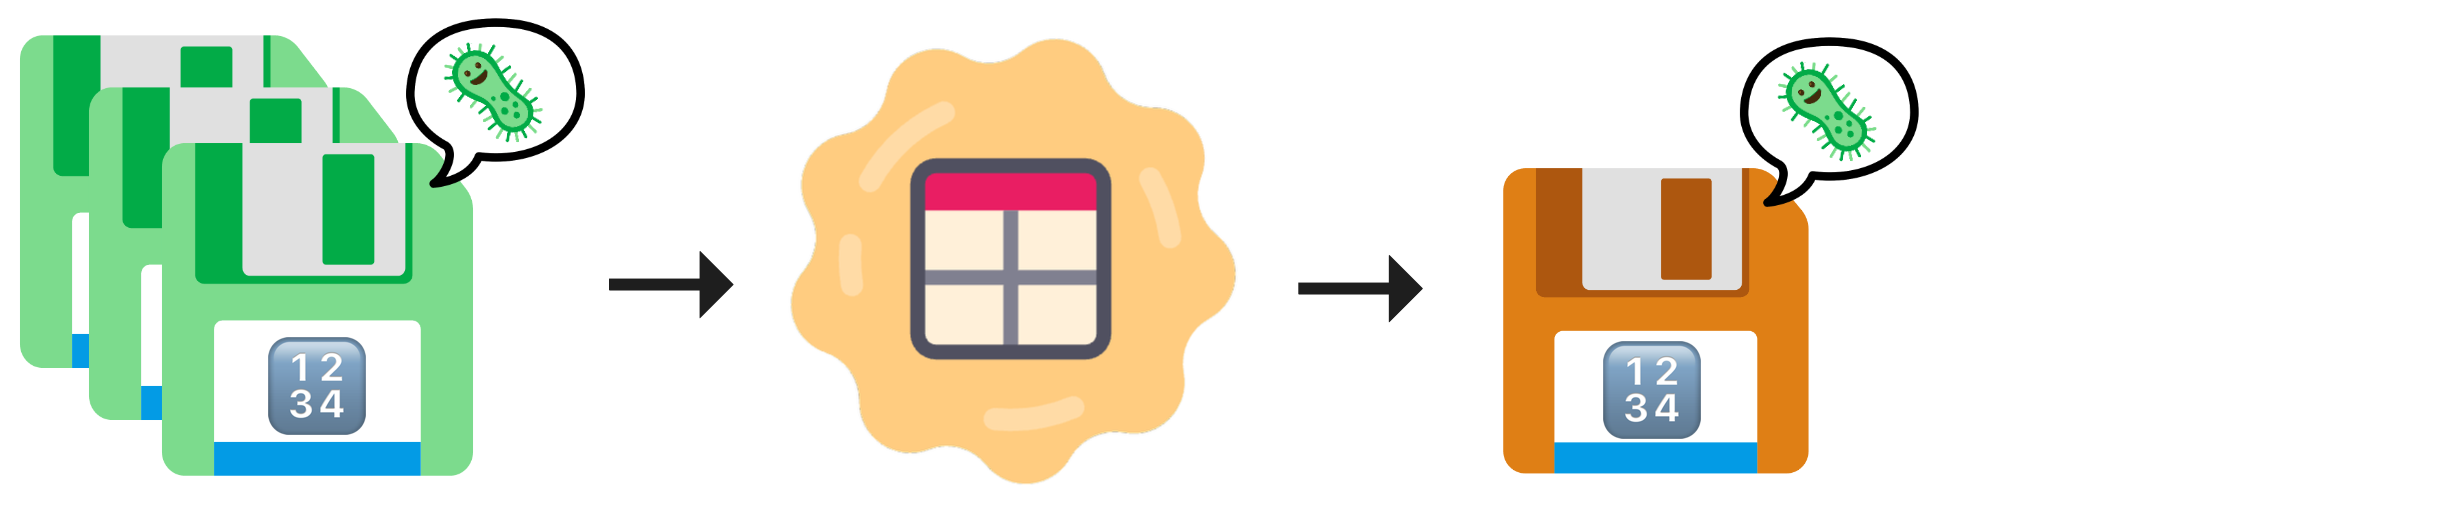

The high-dimensional feature tables produced by CellProfiler often vary in format depending on the imaging pipeline, experiment, or storage system. CytoTable standardizes these single-cell morphology datasets by harmonizing outputs into consistent, analysis-ready formats such as Parquet or AnnData. This unification ensures that data from diverse experiments can be readily integrated and processed by downstream profiling tools like Pycytominer or coSMicQC, enabling scalable and reproducible cytomining workflows.

We use CytoTable below to process the numeric feature data observed above.

In [7]:
%%time

# run cytotable convert
result = cytotable.convert(
    source_path=source_path,
    dest_path=dest_path,
    # specify a destination data format type
    dest_datatype="parquet",
    # specify a preset which enables quick use of common input file formats
    preset="cellprofiler_csv",
)
print(pathlib.Path(result).name)

example.parquet
CPU times: user 215 ms, sys: 159 ms, total: 374 ms
Wall time: 13.1 s


In [8]:
# show the table head using pandas
pq.read_table(source=result).to_pandas().head()

,Metadata_ImageNumber,Metadata_Cells_Parent_Nuclei,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_ObjectNumber,Image_FileName_DNA,Image_FileName_OrigOverlay,Image_FileName_PH3,Image_FileName_cellbody,Cytoplasm_AreaShape_Area,...,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Nuclei_Location_Center_Z,Nuclei_Location_MaxIntensity_X_DNA,Nuclei_Location_MaxIntensity_X_PH3,Nuclei_Location_MaxIntensity_Y_DNA,Nuclei_Location_MaxIntensity_Y_PH3,Nuclei_Location_MaxIntensity_Z_DNA,Nuclei_Location_MaxIntensity_Z_PH3,Nuclei_Number_Object_Number
0,1,1,1,1,1,AS_09125_050116030001_D03f00d0.tif,AS_09125_050116030001_D03f00d0_Overlay.png,AS_09125_050116030001_D03f00d1.tif,AS_09125_050116030001_D03f00d2.tif,288,...,477.099237,7.580153,0,477.0,478.0,8.0,13.0,0.0,0.0,1
1,1,2,2,2,2,AS_09125_050116030001_D03f00d0.tif,AS_09125_050116030001_D03f00d0_Overlay.png,AS_09125_050116030001_D03f00d1.tif,AS_09125_050116030001_D03f00d2.tif,256,...,495.750000,11.098684,0,495.0,502.0,9.0,14.0,0.0,0.0,2
2,1,3,3,3,3,AS_09125_050116030001_D03f00d0.tif,AS_09125_050116030001_D03f00d0_Overlay.png,AS_09125_050116030001_D03f00d1.tif,AS_09125_050116030001_D03f00d2.tif,52,...,438.959184,11.374150,0,440.0,439.0,11.0,16.0,0.0,0.0,3
3,1,4,4,4,4,AS_09125_050116030001_D03f00d0.tif,AS_09125_050116030001_D03f00d0_Overlay.png,AS_09125_050116030001_D03f00d1.tif,AS_09125_050116030001_D03f00d2.tif,466,...,80.459184,11.163265,0,80.0,81.0,13.0,10.0,0.0,0.0,4
4,1,5,5,5,5,AS_09125_050116030001_D03f00d0.tif,AS_09125_050116030001_D03f00d0_Overlay.png,AS_09125_050116030001_D03f00d1.tif,AS_09125_050116030001_D03f00d2.tif,296,...,58.423077,15.509615,0,62.0,52.0,14.0,15.0,0.0,0.0,5


In [9]:
# show metadata for the result file
pq.read_metadata(result)

  created_by: parquet-cpp-arrow version 21.0.0
  num_columns: 312
  num_rows: 289
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 87760

In [10]:
# show schema metadata which includes CytoTable information
# note: this information will travel with the file.
pq.read_schema(result).metadata

{b'data-producer': b'https://github.com/cytomining/CytoTable',
 b'data-producer-version': b'1.1.0.post6.dev0+4ddbbe1'}

In [11]:
# show schema column name summaries
print("Column name prefix counts:")
dict(Counter(w.split("_", 1)[0] for w in pq.read_schema(result).names))

Column name prefix counts:


{'Metadata': 5, 'Image': 4, 'Cytoplasm': 99, 'Cells': 101, 'Nuclei': 103}

In [12]:
# show full schema details
pq.read_schema(result)

Metadata_ImageNumber: int64
Metadata_Cells_Parent_Nuclei: int64
Metadata_Cytoplasm_Parent_Cells: int64
Metadata_Cytoplasm_Parent_Nuclei: int64
Metadata_ObjectNumber: int64
Image_FileName_DNA: string
Image_FileName_OrigOverlay: string
Image_FileName_PH3: string
Image_FileName_cellbody: string
Cytoplasm_AreaShape_Area: int64
Cytoplasm_AreaShape_BoundingBoxArea: int64
Cytoplasm_AreaShape_BoundingBoxMaximum_X: int64
Cytoplasm_AreaShape_BoundingBoxMaximum_Y: int64
Cytoplasm_AreaShape_BoundingBoxMinimum_X: int64
Cytoplasm_AreaShape_BoundingBoxMinimum_Y: int64
Cytoplasm_AreaShape_Center_X: double
Cytoplasm_AreaShape_Center_Y: double
Cytoplasm_AreaShape_Compactness: double
Cytoplasm_AreaShape_Eccentricity: double
Cytoplasm_AreaShape_EquivalentDiameter: double
Cytoplasm_AreaShape_EulerNumber: int64
Cytoplasm_AreaShape_Extent: double
Cytoplasm_AreaShape_FormFactor: double
Cytoplasm_AreaShape_MajorAxisLength: double
Cytoplasm_AreaShape_MaxFeretDiameter: double
Cytoplasm_AreaShape_MaximumRadius: d